In [1]:
# Import the data libraries.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Load IMDB dataset with top 10,000 words only
num_words = 10000
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=num_words)

# Decode function (optional for inspection)
word_index = keras.datasets.imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decode_review = lambda text: ' '.join([reverse_word_index.get(i - 3, '?') for i in text])


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Building a model with embeding layer.
maxlen = 150

# Pad sequences
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

# Restrict training samples to 100
x_train_small = x_train[:100]
y_train_small = y_train[:100]

# Use 10,000 validation samples
x_val_10k = x_val[:10000]
y_val_10k = y_val[:10000]


In [4]:
# Building a model with LSTM layer.

def build_model_with_embedding():
    model = keras.Sequential([
        layers.Embedding(num_words, 128, input_length=maxlen),
        layers.LSTM(32),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_emb = build_model_with_embedding()
history_emb = model_emb.fit(x_train_small, y_train_small, epochs=10, batch_size=32,
                            validation_data=(x_val_10k, y_val_10k), verbose=2)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


4/4 - 10s - 2s/step - accuracy: 0.5800 - loss: 0.6916 - val_accuracy: 0.5065 - val_loss: 0.6927
Epoch 2/10
4/4 - 14s - 3s/step - accuracy: 0.7000 - loss: 0.6761 - val_accuracy: 0.5030 - val_loss: 0.6925
Epoch 3/10
4/4 - 11s - 3s/step - accuracy: 0.7000 - loss: 0.6589 - val_accuracy: 0.5033 - val_loss: 0.6920
Epoch 4/10
4/4 - 15s - 4s/step - accuracy: 0.7500 - loss: 0.6379 - val_accuracy: 0.5030 - val_loss: 0.6922
Epoch 5/10
4/4 - 11s - 3s/step - accuracy: 0.7600 - loss: 0.6034 - val_accuracy: 0.5030 - val_loss: 0.6953
Epoch 6/10
4/4 - 15s - 4s/step - accuracy: 0.7200 - loss: 0.5477 - val_accuracy: 0.5028 - val_loss: 0.7165
Epoch 7/10
4/4 - 10s - 3s/step - accuracy: 0.7300 - loss: 0.4736 - val_accuracy: 0.5051 - val_loss: 0.7378
Epoch 8/10
4/4 - 10s - 3s/step - accuracy: 0.8900 - loss: 0.3683 - val_accuracy: 0.5893 - val_loss: 0.6718
Epoch 9/10
4/4 - 11s - 3s/step - accuracy: 1.0000 - loss: 0.2702 - val_accuracy: 0.6351 - val_loss: 0.7015
Epoch 10/10
4/4 - 16s - 4s/step - accuracy: 0.99

In [5]:
# Downloading GloVe embeddings & preparing pre-trained embeddings.

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

# Load embeddings
embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coef = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coef

# Prepare embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


--2025-04-20 14:26:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-20 14:26:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-20 14:26:49--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [6]:
#Builing a model by using pre-trained GloVe embedings.

def build_model_with_pretrained():
    model = keras.Sequential([
        layers.Embedding(num_words, embedding_dim, input_length=maxlen,
                         weights=[embedding_matrix], trainable=False),
        layers.LSTM(32),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_glove = build_model_with_pretrained()
history_glove = model_glove.fit(x_train_small, y_train_small, epochs=10, batch_size=32,
                                validation_data=(x_val_10k, y_val_10k), verbose=2)

Epoch 1/10
4/4 - 10s - 3s/step - accuracy: 0.4200 - loss: 0.7177 - val_accuracy: 0.4951 - val_loss: 0.7061
Epoch 2/10
4/4 - 8s - 2s/step - accuracy: 0.6000 - loss: 0.6782 - val_accuracy: 0.4992 - val_loss: 0.7108
Epoch 3/10
4/4 - 10s - 3s/step - accuracy: 0.5900 - loss: 0.6654 - val_accuracy: 0.4852 - val_loss: 0.7032
Epoch 4/10
4/4 - 10s - 3s/step - accuracy: 0.6400 - loss: 0.6557 - val_accuracy: 0.4853 - val_loss: 0.7023
Epoch 5/10
4/4 - 15s - 4s/step - accuracy: 0.7100 - loss: 0.6476 - val_accuracy: 0.4875 - val_loss: 0.7029
Epoch 6/10
4/4 - 16s - 4s/step - accuracy: 0.7000 - loss: 0.6412 - val_accuracy: 0.4905 - val_loss: 0.7036
Epoch 7/10
4/4 - 15s - 4s/step - accuracy: 0.7300 - loss: 0.6299 - val_accuracy: 0.4915 - val_loss: 0.7088
Epoch 8/10
4/4 - 10s - 3s/step - accuracy: 0.6900 - loss: 0.6192 - val_accuracy: 0.4978 - val_loss: 0.7193
Epoch 9/10
4/4 - 11s - 3s/step - accuracy: 0.6600 - loss: 0.6096 - val_accuracy: 0.4990 - val_loss: 0.7265
Epoch 10/10
4/4 - 11s - 3s/step - accu

In [7]:
#Repeat training.

from tensorflow import keras
from tensorflow.keras import layers

def build_model_with_embedding():
    model = keras.Sequential([
        layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen),
        layers.LSTM(32),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_emb = build_model_with_embedding()
history_emb = model_emb.fit(x_train_small, y_train_small, epochs=10, batch_size=32,
                            validation_data=(x_val_10k, y_val_10k), verbose=2)


Epoch 1/10
4/4 - 10s - 2s/step - accuracy: 0.4800 - loss: 0.6923 - val_accuracy: 0.5045 - val_loss: 0.6929
Epoch 2/10
4/4 - 8s - 2s/step - accuracy: 0.6200 - loss: 0.6813 - val_accuracy: 0.5031 - val_loss: 0.6927
Epoch 3/10
4/4 - 10s - 3s/step - accuracy: 0.6200 - loss: 0.6704 - val_accuracy: 0.5034 - val_loss: 0.6924
Epoch 4/10
4/4 - 8s - 2s/step - accuracy: 0.6700 - loss: 0.6564 - val_accuracy: 0.5033 - val_loss: 0.6924
Epoch 5/10
4/4 - 13s - 3s/step - accuracy: 0.7000 - loss: 0.6356 - val_accuracy: 0.5033 - val_loss: 0.6929
Epoch 6/10
4/4 - 17s - 4s/step - accuracy: 0.7100 - loss: 0.6058 - val_accuracy: 0.5035 - val_loss: 0.6958
Epoch 7/10
4/4 - 9s - 2s/step - accuracy: 0.6900 - loss: 0.5545 - val_accuracy: 0.5028 - val_loss: 0.7324
Epoch 8/10
4/4 - 10s - 2s/step - accuracy: 0.6400 - loss: 0.5004 - val_accuracy: 0.5040 - val_loss: 0.7431
Epoch 9/10
4/4 - 11s - 3s/step - accuracy: 0.8200 - loss: 0.4084 - val_accuracy: 0.5296 - val_loss: 0.6964
Epoch 10/10
4/4 - 15s - 4s/step - accura

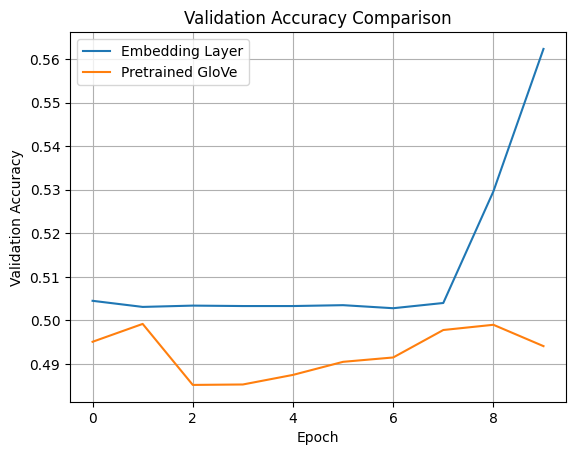

In [8]:
#Comparison plot-embeding vs pre-trained GloVe accuracy.

import matplotlib.pyplot as plt

plt.plot(history_emb.history['val_accuracy'], label='Embedding Layer')
plt.plot(history_glove.history['val_accuracy'], label='Pretrained GloVe')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
#Evaluate impact of different sample sizes.

sample_sizes = [100, 500, 1000, 5000]
accuracies = []
losses = []

for size in sample_sizes:
    print(f"\nTraining with {size} samples...")

    model = build_model_with_embedding()  # Reuse the function from earlier
    model.fit(x_train[:size], y_train[:size], epochs=5, batch_size=32,
              validation_data=(x_val_10k, y_val_10k), verbose=0)

    loss, acc = model.evaluate(x_val_10k, y_val_10k, verbose=0)
    accuracies.append(round(acc, 4))
    losses.append(round(loss, 4))
    print(f"Done — Accuracy: {acc:.4f}, Loss: {loss:.4f}")

    import pandas as pd

# Create and display DataFrame
df_summary = pd.DataFrame({
    'Training Size': sample_sizes,
    'Validation Accuracy': accuracies,
    'Validation Loss': losses
})

df_summary



Training with 100 samples...
Done — Accuracy: 0.5026, Loss: 0.6957

Training with 500 samples...
Done — Accuracy: 0.7338, Loss: 0.6406

Training with 1000 samples...
Done — Accuracy: 0.7480, Loss: 0.6290

Training with 5000 samples...
Done — Accuracy: 0.8113, Loss: 0.5842


,Training Size,Validation Accuracy,Validation Loss
0,100,0.5026,0.6957
1,500,0.7338,0.6406
2,1000,0.7480,0.6290
3,5000,0.8113,0.5842
